In [34]:
# utilities
import pandas as pd 
import numpy as np
import datetime
from datetime import datetime as dt
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')

# plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#model
from statsmodels.tsa.stattools import grangercausalitytests #for causality check
from statsmodels.tsa.stattools import adfuller #for stationarity check
from statsmodels.tsa.seasonal import seasonal_decompose #for the decomposition
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

Importing datasets

In [4]:
co2 = pd.read_csv('co2.csv')

no_raindays = pd.read_csv('rainfall-monthly-number-of-rain-days.csv')
no_raindays.rename(columns={'month':'Date'},inplace=True)

sea_level = pd.read_csv('sea_level.csv')
sea_level.rename(columns = {'Time':'Date'},inplace=True)

humidity = pd.read_csv('relative-humidity-monthly-mean.csv')
humidity.rename(columns = {'month':'Date'},inplace=True)

rainfall = pd.read_csv('rainfall-monthly-total.csv')
rainfall.rename(columns = {'month':'Date'},inplace=True)

temperature = pd.read_csv('surface-air-temperature-monthly-mean.csv')
temperature.rename(columns = {'month':'Date'},inplace=True)

anomaly_temperature = pd.read_csv('anomalies_temperature.csv')

Append new data to: co2, sea_level,anomaly_temperature in order to have data until the 2021.

First thing is to create a new list of dates then create the values of the measurement according to the values in the dataframe.

Change datatype of the column with the date into the datetime format 'YYYY-mm'

In [5]:
co2['Date'] = pd.to_datetime(co2['Date'], format = '%Y-%m')
co2['Date'] = co2['Date'].dt.strftime('%Y-%m')

sea_level['Date'] = pd.to_datetime(sea_level['Date'], format = '%Y-%m')
sea_level['Date'] = sea_level['Date'].dt.strftime('%Y-%m')

humidity['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
humidity['Date'] = humidity['Date'].dt.strftime('%Y-%m')

rainfall['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
rainfall['Date'] = rainfall['Date'].dt.strftime('%Y-%m')

temperature['Date'] = pd.to_datetime(temperature['Date'], format = '%Y-%m')
temperature['Date'] = temperature['Date'].dt.strftime('%Y-%m')

anomaly_temperature['Date'] = pd.to_datetime(anomaly_temperature['Date'], format = '%Y-%m')
anomaly_temperature['Date'] = anomaly_temperature['Date'].dt.strftime('%Y-%m')

Now that the dataframes are modified and the cols have the same name and format, i can merge them on the Date and build a unique dataframe.

In [6]:
climate_change = no_raindays.merge(rainfall,on='Date').merge(humidity,on='Date').merge(temperature,on='Date').merge(co2,on='Date').merge(sea_level,on='Date').merge(anomaly_temperature,on='Date')
climate_change.tail()

,Date,no_of_rainy_days,total_rainfall,relative_humidity,surface_temp,co2,GMSL(Global Mean Sea Level),Anomalies_Land_Ocean_Temperature
473,2021-06,20,93.4,77.8,28.5,427.2,13.5,2.59
474,2021-07,12,195.8,76.5,28.6,428.0,13.5,2.62
475,2021-08,24,293.6,80.4,27.6,428.8,13.6,2.65
476,2021-09,14,205.4,77.3,28.3,429.6,13.6,2.68
477,2021-10,14,177.0,78.3,28.5,430.4,13.7,2.71


In [7]:
# change the column values from percentage to decimal 
climate_change['relative_humidity'] = climate_change['relative_humidity'].apply(lambda x: x / 100)
#save the dataframe to csv
climate_change.to_csv('climate_change.csv',index=False)

In [27]:
climate_change = pd.read_csv('climate_change.csv')

In [25]:
#check there are no missing values
climate_change.isna().sum()

Date                                0
no_of_rainy_days                    0
total_rainfall                      0
relative_humidity                   0
surface_temp                        0
co2                                 0
GMSL(Global Mean Sea Level)         0
Anomalies_Land_Ocean_Temperature    0
dtype: int64

### EDA & DATA VISUALIZATION

In [9]:
def correlation(data : pd.core.frame.DataFrame):
    corr_matrix = data.corr()
    mask = np.zeros_like(corr_matrix) #to plot only a half matrix
    mask[np.triu_indices_from(mask)] = True #to generate a mask for the upper triangle
    sns.heatmap(corr_matrix, mask=mask, square=True,cmap="PuOr_r")
    return

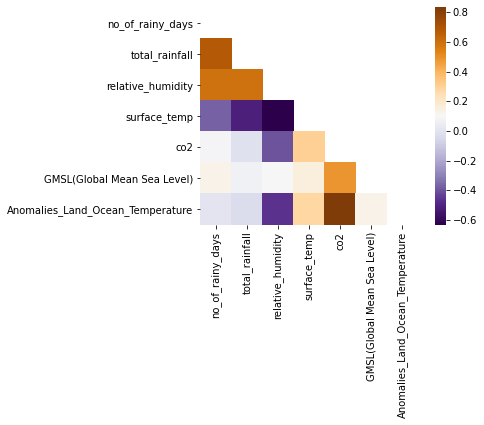

In [10]:
correlation(climate_change)

Autocorrelation

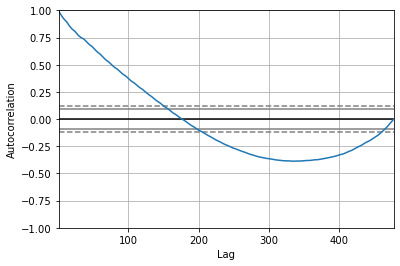

In [11]:
pd.plotting.autocorrelation_plot(climate_change['co2'])
plt.show()
# from this plot we can see that there is a positive correlation with the first 100-to-180 lags that is perhaps 
# significant for the the first 150 lags.

# Hence a good starting point for the AR parametere for co2 could be 100.

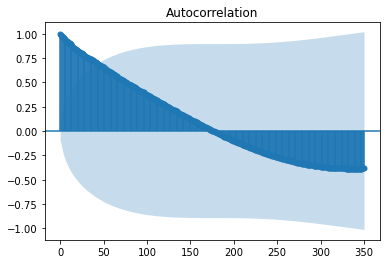

In [12]:
plot_acf(climate_change['co2'], lags=350)
plt.show()

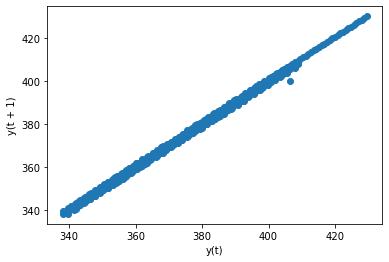

In [13]:
pd.plotting.lag_plot(climate_change['co2'])
plt.show()

Partial autocorrelation

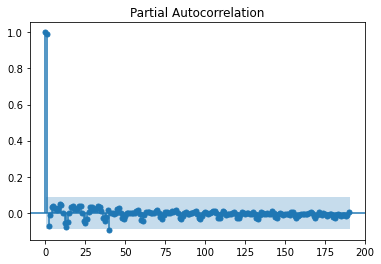

In [14]:
plot_pacf(climate_change['co2'], lags=190)
plt.show()

Time series decomposition - do it for all the variables - 

In [ ]:
# # Multiplicative Decomposition 
# climate_change['co2'].index = pd.to_datetime(climate_change['co2'].index) 
# decomp_mul = seasonal_decompose(climate_change['co2'], model='multiplicative', extrapolate_trend='freq', period=12)
# decomp_mul.plot()
# plt.show()

# # Additive Decomposition
# decomp_add = seasonal_decompose(climate_change['co2'], model='additive', extrapolate_trend='freq', period=12)
# decomp_add.plot()
# plt.show()

## VARIMA (Vector Arima for multivariate time series forecasting)

Steps:

 1) Causality investigation
 2) Test for stationary
 3) Model 
 4) Prediction
 4) Evaluation


In [33]:
''' 1. CAUSALITY INVESTIGATION 
The Granger Causality Test is used to investigate causality of data: check if a particular variable comes before 
another in the time series.
The Null Hypothesis of the Granger Causality Test is that lagged x-values do not explain the variation in y
(so the x does not cause y).
The critical value used is 5% and if the p-value of a pair of variables is smaller than the significance level, 
then the Null Hypothesis (that the coefficients of the corresponding past values is zero, that is, the X does not 
cause Y) can be rejected.
In the output the rows are the response variable and the columns are the predictors
'''
maxlag=15
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables) #create the df for the results
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False) #perform the test
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#climate_change.set_index('Date',inplace=True)
climate_change = pd.read_csv('climate_change.csv', index_col='Date')
grangers_causation_matrix(climate_change, variables = climate_change.columns)   

,no_of_rainy_days_x,total_rainfall_x,relative_humidity_x,surface_temp_x,co2_x,GMSL(Global Mean Sea Level)_x,Anomalies_Land_Ocean_Temperature_x
no_of_rainy_days_y,1.0000,0.0024,0.0000,0.0000,0.0000,0.0317,0.0053
total_rainfall_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.1896,0.1522
relative_humidity_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.3026,0.0000
surface_temp_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.3210,0.0000
co2_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0544,0.0000
GMSL(Global Mean Sea Level)_y,0.0227,0.0179,0.0031,0.0750,0.3634,1.0000,0.0566
Anomalies_Land_Ocean_Temperature_y,0.0057,0.0106,0.0007,0.0001,0.0007,0.0166,1.0000


Let's analyze the result obtained. For most of the variables, since the p-values are < 0.05, i can reject the null hypothesis and use them for the VARIMA model. 

But for some variables i can't reject the null hypothesis, in fact the p-values for:
- (GMSL_x,total_rainfall_y) - (GMSL_x,relative_humidity_y) - (GMSL_x,surface_temp_y) 

- (Anomalies_Land_Ocean_Temperature_x,total_rainfall_y)

- (co2_x,GMSL(Global Mean Sea Level)_y)

are bigger than 0.05. That means that the **GMSL doesn't cause the total rainfall, the relative humidity and the surface temperature**, as well as the **Anomalies_Land_Ocean_Temperature doesn't cause the total rainfall** and the **co2 doesn't cause the mean sea level**. 

*As it can be notice, this analysis makes sense since - for example - it's reasonable that the total rainfall causes the surface temperature, the humidity and the anomalies in the temperature; just as it would have made less sense if the co2 emissions causes the Sea Level - but for sure it causes the surface temperature.*

In the end I can state that, exept for the GMSL and the others two pairs listed before, the other variables are interchangeably causing each other. 

For now on i will not include the GMSL in the model.

In [98]:
#CLIMATE DATA WITHOUT GMSL
data_cc = climate_change.drop(['GMSL(Global Mean Sea Level)'],axis=1)

In [78]:
''' 2. STATIONARITY TEST
VectorARMA requires time series to be stationary(mean and variance does not change over time), to test it
i use the ADF Test.
'''

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary")

for name, column in data_cc.iteritems():
    adfuller_test(column, name=column.name)


 no_of_rainy_days : P-Value = 0.0 => Stationary
 total_rainfall : P-Value = 0.0 => Stationary
 relative_humidity : P-Value = 0.233 => Non-stationary
 surface_temp : P-Value = 0.0 => Stationary
 co2 : P-Value = 0.999 => Non-stationary
 Anomalies_Land_Ocean_Temperature : P-Value = 0.999 => Non-stationary


In [175]:
# Train-test splitting
n_obs = 12 #forecast on the next 12 observation (12 months = one year)
train,test =  data_cc[0:-n_obs], data_cc[-n_obs:]

'''
Since for the relative_humidity,co2 and Anomalies_Land_Ocean_Temperature the test fails, 
i need to make the data stationary (eliminating the trend and seasonality by differencing.
Differencing reduces the length of the series by 1 and since all the time series has to be of the same length, 
i apply the diff() method to all the series.
'''
data_differenced = train.diff().dropna() #diffence the train data
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)


 no_of_rainy_days : P-Value = 0.0 => Stationary
 total_rainfall : P-Value = 0.0 => Stationary
 relative_humidity : P-Value = 0.0 => Stationary
 surface_temp : P-Value = 0.0 => Stationary
 co2 : P-Value = 0.001 => Stationary
 Anomalies_Land_Ocean_Temperature : P-Value = 0.0 => Stationary


In [176]:
data_differenced.describe()

,no_of_rainy_days,total_rainfall,relative_humidity,surface_temp,co2,Anomalies_Land_Ocean_Temperature
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,0.012903,-0.060860,-0.000125,0.005161,0.171032,0.004860
std,5.873656,143.191929,0.029113,0.600552,0.953497,0.118981
min,-20.000000,-569.000000,-0.094000,-1.700000,-6.390000,-0.330000
25%,-4.000000,-76.800000,-0.018000,-0.400000,-0.150000,-0.070000
50%,0.000000,5.200000,0.000000,0.000000,0.400000,0.020000
75%,4.000000,79.200000,0.018000,0.400000,0.800000,0.080000
max,18.000000,580.300000,0.120000,1.900000,1.670000,0.370000


In [177]:
# To find the optimal values of p I will perform the model.select_order() method that highlight
# with a * the lowest AIC value.
model = VAR(data_differenced)
x = model.select_order(maxlags=16)
x.summary()

,AIC,BIC,FPE,HQIC
0,-1.106,-1.051,0.3308,-1.085
1,-2.559,-2.175,0.07735,-2.408
2,-3.215,-2.501,0.04016,-2.934
3,-4.018,-2.976,0.01799,-3.607
4,-4.379,-3.007*,0.01254,-3.838
5,-4.546,-2.845,0.01062,-3.876*
6,-4.669,-2.638,0.009406,-3.868
7,-4.737,-2.377,0.008796,-3.807
8,-4.773,-2.083,0.008502,-3.713
9,-4.844,-1.826,0.007932,-3.655


As the value of the P increases model becomes more complex and the AIC penalizes the complex model.

As can be seen from the result, the AIC begins to drop as i fit the more complex model (around 11) but, after a certain amount of time AIC begins to increase again (from 13). It’s because AIC is punishing these models for being too complex.

The VAR(p=12) returns the lowest score and after that again AIC starts increasing, hence i will build the VAR model of order 12. 

In [ ]:
# train the VAR model of selected order (p=12)
p=12
model_fitted = model.fit(p) 
model_fitted.summary()

Durbin-Watson Statistic 

Test to check the autocorrelation. The result of this test will be a value in range [0.0,4.0]. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

In [179]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)
for col,val in zip (data_differenced.columns,out):
    print((col),':',round(val,2))

no_of_rainy_days : 1.97
total_rainfall : 1.97
relative_humidity : 1.97
surface_temp : 1.98
co2 : 2.04
Anomalies_Land_Ocean_Temperature : 1.94


From the results obtained I can state that there is no autocorrelation, since all values are in the range [1.5,2] hence i can procede with the forecasting

PREDICTION

In order to forecast, the VAR model expects up to the lag order number of observations from the past data since the terms in the VAR model are essentially the lags of the various time series in the dataset.

In [213]:
lag = model_fitted.k_ar #12

# input data for forecasting
lagged_Values = data_differenced.values[-lag:] # specify the 'initial value' for the forecast

# Forecast
pred = model_fitted.forecast(y= lagged_Values,steps= n_obs) #pred = model_fitted.forecast(y=data_differenced.values, steps=n_obs) 
df_pred = (pd.DataFrame(pred, index=test.index, columns=test.columns + '_pred'))
#df_pred = pd.DataFrame(pred, columns=data_differenced.columns + '_pred')
df_pred

,no_of_rainy_days_pred,total_rainfall_pred,relative_humidity_pred,surface_temp_pred,co2_pred,Anomalies_Land_Ocean_Temperature_pred
Date,,,,,,
2020-11,2.988035,135.392134,0.032497,-0.481104,0.842476,0.019958
2020-12,-0.641425,64.911254,0.011693,-0.392197,0.626267,-0.057816
2021-01,-1.153047,-58.665482,-0.009799,-0.037645,0.252269,0.098899
2021-02,-1.269499,-19.006710,-0.006718,0.071336,0.095361,-0.031953
2021-03,1.473870,40.209120,-0.005897,0.221731,0.333099,0.042238
2021-04,0.128105,-52.153070,-0.001418,0.216724,0.514408,-0.016811
2021-05,-0.261148,-25.317664,0.001230,0.022891,0.629350,0.011990
2021-06,1.100786,39.705717,0.002178,-0.057278,0.222612,-0.014978
2021-07,1.185520,36.292625,0.005832,-0.355554,0.199802,0.003154


INVERT THE TRANSFORMATION

Notice that the forecasted value is a first-order difference. To get it similar to original data i have to 'roll back' each difference by taking the most recent values of the original series’ training data and adding it to a cumulative sum of forecasted values (first determine the cumulative sum at index and then add it to the base number)


In [223]:
def invert_transformation(train, pred):
    forecast = pred.copy()
    columns = train.columns
    for col in columns[1:]:
        forecast[str(col)+'_pred'] = train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

result = invert_transformation(train, df_pred)

In [224]:
result

,no_of_rainy_days_pred,total_rainfall_pred,relative_humidity_pred,surface_temp_pred,co2_pred,Anomalies_Land_Ocean_Temperature_pred
Date,,,,,,
2020-11,18.988035,214.192134,0.786497,27.818896,421.642476,2.369958
2020-12,18.346610,279.103389,0.798190,27.426698,422.268744,2.312142
2021-01,17.193564,220.437906,0.788392,27.389054,422.521012,2.411041
2021-02,15.924065,201.431196,0.781674,27.460389,422.616373,2.379088
2021-03,17.397935,241.640317,0.775777,27.682120,422.949472,2.421326
2021-04,17.526040,189.487247,0.774359,27.898844,423.463879,2.404515
2021-05,17.264892,164.169583,0.775589,27.921735,424.093230,2.416505
2021-06,18.365678,203.875299,0.777767,27.864457,424.315842,2.401527
2021-07,19.551197,240.167925,0.783600,27.508904,424.515644,2.404681


### Plot the result

In [ ]:
# #Plot
# plt.figure(figsize=(12,5), dpi=200)
# plt.plot(train['no_of_rainy_days'][:n_obs], label='training')
# plt.plot(test['no_of_rainy_days'][-n_obs:], label='actual')
# plt.plot(df_prediction['no_of_rainy_days_P'], label='forecast')
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

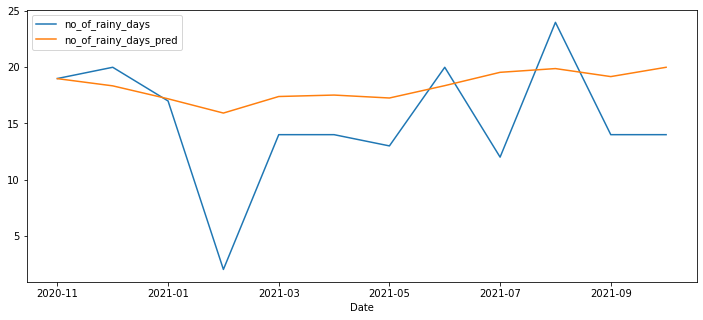

In [225]:
test_or = data_cc[-n_obs:]
test_or['no_of_rainy_days'].plot(figsize=(12,5),legend=True);
result['no_of_rainy_days_pred'].plot(legend=True);

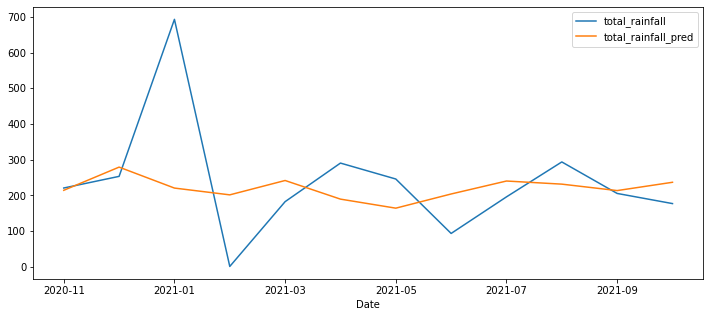

In [226]:
test_or['total_rainfall'].plot(figsize=(12,5),legend=True);
result['total_rainfall_pred'].plot(legend=True);

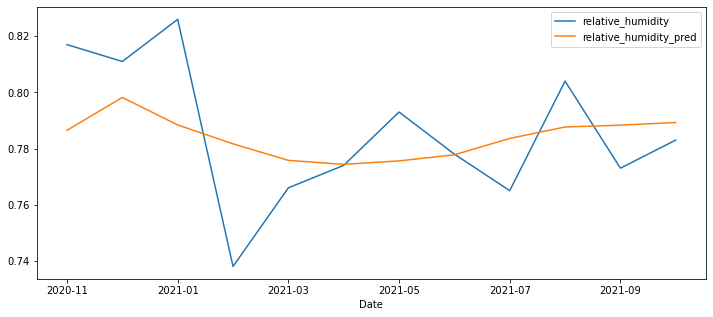

In [227]:
test_or['relative_humidity'].plot(figsize=(12,5),legend=True);
result['relative_humidity_pred'].plot(legend=True);

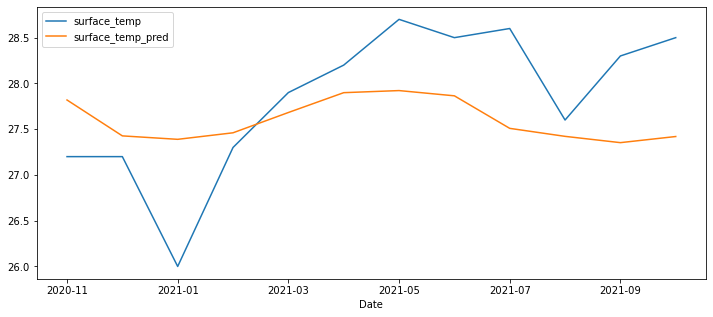

In [228]:
test_or['surface_temp'].plot(figsize=(12,5),legend=True);
result['surface_temp_pred'].plot(legend=True);

### Evaluate the forecast

In [233]:
#combining predicted and real data set
combine = pd.concat([result['surface_temp_pred'], test['surface_temp']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.surface_temp_pred /row.surface_temp *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

In [234]:
combine

,Date,surface_temp_pred,surface_temp,accuracy
11,2021-10,27.42,28.5,96.21%
10,2021-09,27.35,28.3,96.65%
9,2021-08,27.42,27.6,99.35%
8,2021-07,27.51,28.6,96.18%
7,2021-06,27.86,28.5,97.77%
6,2021-05,27.92,28.7,97.29%
5,2021-04,27.90,28.2,98.93%
4,2021-03,27.68,27.9,99.22%
3,2021-02,27.46,27.3,100.59%
2,2021-01,27.39,26.0,105.34%


In [158]:
from statsmodels.tsa.stattools import acf
from sklearn import metrics

def forecast_eval(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**0.5  # RMSE
    r2 = metrics.r2_score(actual, forecast)  #R²

    return({'rmse':rmse, 'R²':r2})

def adjust(val, length= 6): 
    return str(val).ljust(length)

In [159]:
print('Forecast evaluation of: no_of_rainy_days')
accuracy_prod = forecast_eval(df_prediction['no_of_rainy_days_pred'].values, ['no_of_rainy_days'])

for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast evaluation of: no_of_rainy_days


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')